# Random Forest

Neste caderno, apresentaremos os modelos de floresta aleatórios e mostraremos as diferenças com os conjuntos de ensacamento.

Florestas aleatórias são um modelo popular em aprendizado de máquina. Eles são uma modificação do algoritmo de bagging. No bagging, qualquer classificador ou regressor pode ser usado. Em florestas aleatórias, o classificador ou regressor base é sempre uma árvore de decisão.

Florestas aleatórias têm outra particularidade: ao treinar uma árvore, a busca pela melhor divisão é feita apenas em um subconjunto das características originais tomadas aleatoriamente. Os subconjuntos aleatórios são diferentes para cada nó dividido. O objetivo é injetar randomização adicional no procedimento de aprendizagem para tentar descorrelacionar os erros de predição das árvores individuais.

Portanto, as florestas aleatórias estão usando a randomização em ambos os eixos da matriz de dados:

por bootstrapping de amostras para cada árvore na floresta;
selecionar aleatoriamente um subconjunto de recursos em cada nó da árvore.

Uma olhada em random forest

Ilustraremos o uso de um classificador de floresta aleatório no conjunto de dados do censo de adultos.

In [6]:
from urllib.request import urlretrieve 
# lembre de sempre pegar o arquivo do tipo RAW no github 
url = 'https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/master/datasets/adult-census.csv'
urlretrieve(url, 'C:/Users/Rogerio Lopes/Desktop/Rogerio/Machine_Learning_With_Scikit_Learn/Module6_ensemble_of_models/adult-census.csv')

('C:/Users/Rogerio Lopes/Desktop/Rogerio/Machine_Learning_With_Scikit_Learn/Module6_ensemble_of_models/adult-census.csv',
 <http.client.HTTPMessage at 0x230df65d2b0>)

In [14]:
import pandas as pd

adult_census = pd.read_csv("adult-census.csv")
target_name = "class"
data = adult_census.drop(columns=[target_name, "education-num", "native-country"])
target = adult_census[target_name]

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

O censo de adultos contém alguns dados categóricos e codificamos os recursos categóricos usando um OrdinalEncoder, pois os modelos baseados em árvore podem funcionar de maneira muito eficiente com uma representação ingênua de variáveis categóricas.

Uma vez que existem categorias raras neste conjunto de dados, precisamos codificar especificamente categorias desconhecidas no momento da previsão para poder usar a validação cruzada. Caso contrário, algumas categorias raras só poderiam estar presentes no lado da validação da divisão de validação cruzada e o OrdinalEncoder geraria um erro ao chamar seu método de transformação com os pontos de dados do conjunto de validação.

In [15]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

categorical_encoder = OrdinalEncoder()

preprocessor = make_column_transformer(
    (categorical_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough")

Primeiro, daremos um exemplo simples onde treinaremos um único classificador de árvore de decisão e verificaremos seu desempenho de generalização por meio de validação cruzada.

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

tree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0))

In [17]:
from sklearn.model_selection import cross_val_score

scores_tree = cross_val_score(tree, data, target)

print(f"Decision tree classifier: "
      f"{scores_tree.mean():.3f} +/- {scores_tree.std():.3f}")

Decision tree classifier: 0.819 +/- 0.004


De maneira semelhante ao que foi feito no bloco de notas anterior, construímos um BaggingClassifier com um classificador de árvore de decisão como modelo base. Além disso, precisamos especificar quantos modelos queremos combinar. Observe que também precisamos pré-processar os dados e, portanto, usar um pipeline scikit-learn.

In [18]:
from sklearn.ensemble import BaggingClassifier

bagged_trees = make_pipeline(
    preprocessor,
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(random_state=0),
        n_estimators=50, n_jobs=2, random_state=0,
    )
)

In [19]:
scores_bagged_trees = cross_val_score(bagged_trees, data, target)

print(f"Bagged decision tree classifier: "
      f"{scores_bagged_trees.mean():.3f} +/- {scores_bagged_trees.std():.3f}")

Bagged decision tree classifier: 0.845 +/- 0.005


Observe que o desempenho de generalização das árvores ensacadas já é muito melhor do que o desempenho de uma única árvore.

Agora, usaremos uma floresta aleatória. Você observará que não precisamos especificar nenhum base_estimator porque o estimador é forçado a ser uma árvore de decisão. Assim, apenas especificamos o número desejado de árvores na floresta.

In [20]:
from sklearn.ensemble import RandomForestClassifier

random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0)
)

In [21]:
scores_random_forest = cross_val_score(random_forest, data, target)

print(f"Random forest classifier: "
      f"{scores_random_forest.mean():.3f} +/- "
      f"{scores_random_forest.std():.3f}")

Random forest classifier: 0.850 +/- 0.004


Parece que a floresta aleatória está tendo um desempenho ligeiramente melhor do que as árvores ensacadas, possivelmente devido à seleção aleatória das características que decorrelaciona os erros de previsão de árvores individuais e, como consequência, torna a etapa de cálculo da média mais eficiente na redução do sobreajuste.

Detalhes sobre hiperparâmetros padrão
Para florestas aleatórias, é possível controlar a quantidade de aleatoriedade para cada divisão, definindo o valor do hiperparâmetro max_features:

max_features = 0,5 significa que 50% dos recursos são considerados em cada divisão;

max_features = 1.0 significa que todos os recursos são considerados em cada divisão, o que desativa efetivamente a subamostragem de recursos.

Por padrão, RandomForestRegressor desativa a subamostragem do recurso, enquanto RandomForestClassifier usa max_features = np.sqrt (n_features). Esses valores padrão refletem as boas práticas fornecidas na literatura científica.

No entanto, max_features é um dos hiperparâmetros a considerar ao ajustar uma floresta aleatória:

muita aleatoriedade nas árvores pode levar a modelos de base mal ajustados e pode ser prejudicial para o conjunto como um todo,
muito pouca aleatoriedade nas árvores leva a mais correlação dos erros de previsão e, como resultado, reduz os benefícios da etapa de cálculo da média em termos de controle de sobreajuste.
No scikit-learn, as classes de bagging também expõem um parâmetro max_features. No entanto, BaggingClassifier e BaggingRegressor são agnósticos em relação ao seu modelo base e, portanto, a subamostragem de recurso aleatório só pode acontecer uma vez antes de ajustar cada modelo base, em vez de várias vezes por modelo base, como é o caso ao adicionar divisões a uma determinada árvore.

# 📝 Exercício M6.02

O objetivo deste exercício é explorar alguns atributos disponíveis na floresta aleatória do scikit-learn.

Primeiro, ajustaremos o conjunto de dados de regressão dos pinguins.

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

penguins = pd.read_csv("penguins_regression.csv")
feature_names = ["Flipper Length (mm)"]
target_name = "Body Mass (g)"
data, target = penguins[feature_names], penguins[target_name]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

Crie uma random forest contendo três árvores. Treine a floresta e verifique o desempenho da generalização no conjunto de teste em termos de erro médio absoluto.

In [24]:
# solution
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=3)
forest.fit(data_train, target_train)
target_predicted = forest.predict(data_test)
print(f"Mean absolute error: "
      f"{mean_absolute_error(target_test, target_predicted):.3f} grams")

Mean absolute error: 368.211 grams


As próximas etapas deste exercício são:

* criar um novo conjunto de dados contendo os pinguins com comprimento de nadadeira entre 170 mm e 230 mm;
* plotar os dados de treinamento usando um gráfico de dispersão;
* traçar a decisão de cada árvore individual, prevendo no conjunto de dados recém-criado;
* traçar a decisão da floresta aleatória usando este conjunto de dados recém-criado.

In [25]:
# solution
import numpy as np

data_ranges = pd.DataFrame(np.linspace(170, 235, num=300),
                           columns=data.columns)
tree_predictions = []
for tree in forest.estimators_:
    tree_predictions.append(tree.predict(data_ranges))

forest_predictions = forest.predict(data_ranges)

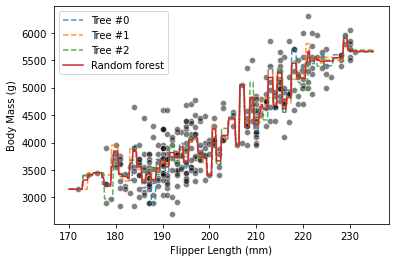

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=penguins, x=feature_names[0], y=target_name,
                color="black", alpha=0.5)

# plot tree predictions
for tree_idx, predictions in enumerate(tree_predictions):
    plt.plot(data_ranges, predictions, label=f"Tree #{tree_idx}",
             linestyle="--", alpha=0.8)

plt.plot(data_ranges, forest_predictions, label=f"Random forest")
_ = plt.legend()